# Separation

Let's think about the essential pieces here:
- a group of particles
    - particles can be moved
    - diagnostic for center of mass
    - diagnostic for moment of inertia
- a random number generator
- a periodic 2d domain

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
class PeriodicSpace:
    def __init__(self, length_x=10, length_y=20):
        self.length_y = length_y
        self.length_x = length_x
        
    def normalize_positions(self, x, y):
        return np.mod(x, self.length_x), np.mod(y, self.length_y)

In [3]:
class Particles:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        x=None, y=None,
        step_length=0.5
    ):
        self.rng = rng
        self.space = space
        self.x, self.y = x, y
        self.step_length = step_length
        self.steps_done = 0

    def move(self):
        self.x += self.step_length * self.rng.normal(size=self.x.shape)
        self.y += self.step_length * self.rng.normal(size=self.y.shape)
        
        self.x, self.y = self.space.normalize_positions(self.x, self.y)
        
        self.steps_done += 1

    def center_of_mass(self):
        return self.x.mean(), self.y.mean()
    
    def moment_of_inertia(self):
        return self.x.var() + self.y.var()

    def diagnostics(self):
        com = self.center_of_mass()
        mi = self.moment_of_inertia()
        return pd.DataFrame(
            {
                "center_of_mass_x": com[0],
                "center_of_mass_y": com[1],
                "moment_of_inertia": mi
            },
            index=[self.steps_done, ],
        
        )

In [4]:
def run_random_walk(
    length_x=10,
    length_y=20,
    number_particles=100,
    number_steps=100,
    step_length=0.5
):
    space = PeriodicSpace(
        length_x=length_x,
        length_y=length_y
    )
    
    rng = np.random.RandomState()
    
    particles = Particles(
        space=space,
        rng=rng,
        x=np.ones((number_particles, )) * length_x / 2.0,
        y=np.ones((number_particles, )) * length_y / 2.0,        
        step_length=step_length
    )
    
    diags = particles.diagnostics()
    
    for step in range(1, number_steps):
        particles.move()
        
        diags = diags.append(
            particles.diagnostics(),
            ignore_index=True
        )
        
    return diags

In [5]:
diags = run_random_walk(number_particles=100, number_steps=1000)

In [6]:
diags

,center_of_mass_x,center_of_mass_y,moment_of_inertia
0,5.000000,10.000000,0.000000
1,5.014128,10.030684,0.561107
2,4.983013,10.043657,0.997435
3,5.017215,9.991422,1.263850
4,4.950674,9.994803,1.866875
...,...,...,...
995,4.740809,10.570497,38.339937
996,4.884953,10.612616,37.614913
997,4.843924,10.569919,38.128512
998,4.788570,10.621142,38.125898


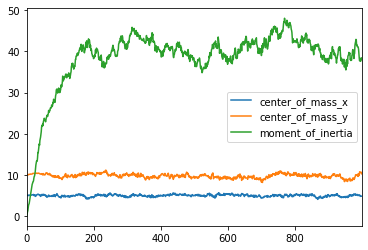

In [7]:
diags.plot();